# Part I: Conformal Regression

We consider a simple regression problem on heteroskedastic data. We want to evaluate the uncertainty associated with the prediction using various conformal prediction methods. The main objective of this first part is to get a better grasp of how Conformal Prediction works, and to *visualize* the effect of the different algorithms on the coverage rate and the size of the prediction intervals. We will code most of the algorithms from scratch, and compare our results with those obtained with help of the PUNCC library for verification purposes.

**Links**
- [PUNCC Github](https://github.com/deel-ai/puncc)
- [PUNCC Documentation](https://deel-ai.github.io/puncc/index.html)

## 0. Setup

**Exercise.** Install the puncc library using pip

In [97]:
!pip install puncc

We import some of the libraries that we will be using throughout.

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

## 1. Dataset

We consider a synthetic 1D heteroskedastic dataset, where the variance of the noise increases with the value of the input feature.
We generate $N$ samples as follows:

- Inputs $X$ are uniformly distributed on $[0, 20]$
- Outputs are given by $Y = (1+\epsilon)\cdot X, $

Such that $\epsilon \sim {\cal N}(\mu=0,\sigma=1)$ is standard gaussian noise.

**Exercise.**
1. Complete the function `heteroskedastic_data` that takes the number of samples `n_samples` to be generated as an arguments, and outputs numpy arrays `X` and `y` of size `n_samples` according to the procedure described above.
2. Use the `heteroskedastic_data` function to generate 4000 samples.

In [99]:
# Generate synthetic 1D heteroskedastic data

def heteroskedastic_data(n_samples):
    X = np.random.uniform(0, 20, n_samples)
    y = (1 + np.random.randn(n_samples)) * X
    X = X.reshape(-1, 1)
    return X, y

n_samples = 4_000
X, y = heteroskedastic_data(n_samples)

**Exercise.** Complete the function `plot_data below`, and use it to plot the synthetic data.

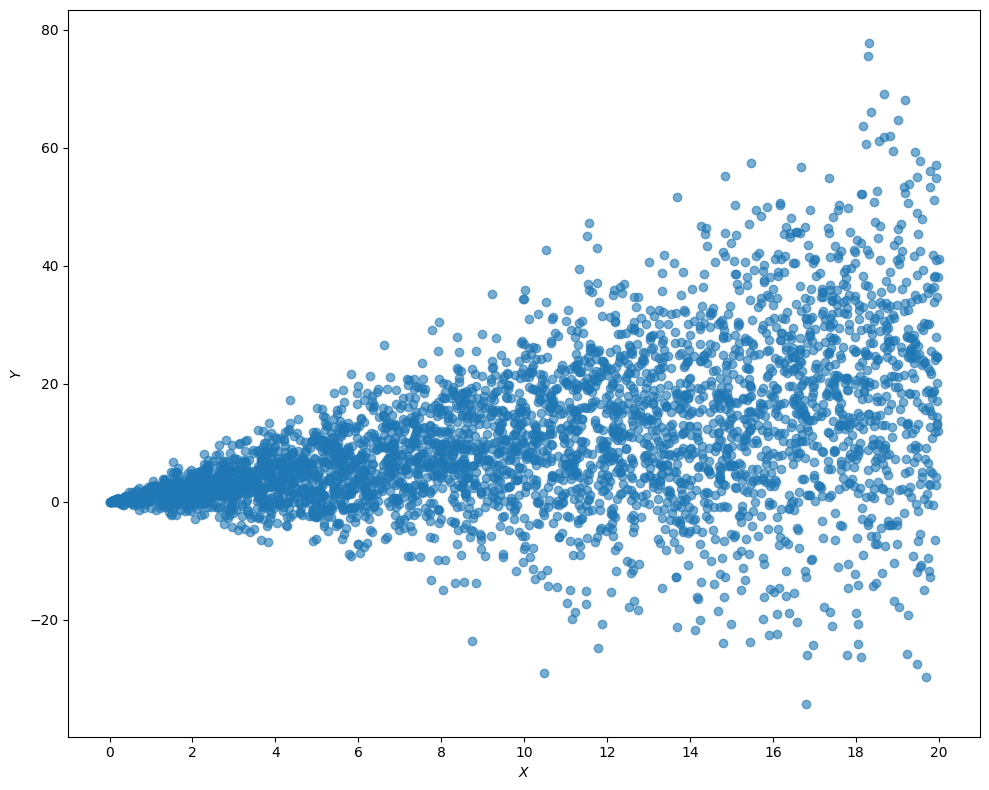

In [100]:
def plot_data(X, y):
    plt.figure(figsize=(10, 8))
    plt.scatter(X, y, alpha=0.6)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_data(X, y)

**Exercise.** Split the data into a training set and a test set by using the `train_test_split` function of the `scikit-learn` library. Split the data randomly and leaving out 25% of the data for the test set.

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## 2. Split Conformal Regression

In order to perform the *split conformal regression* algorithm, we need to split our training data into a *proper training set* (which we will store in the variables `X_fit` and `y_fit`) and a *calibration set*.

**Exercise.** Further split the training data randomly by leaving out 50% of the training data for the calibration set.

In [102]:
X_fit, X_calib, y_fit, y_calib = train_test_split(X_train, y_train, test_size=0.5)

**Exercise.** Train a prediction model using the `LinearRegression` class in the `scikit-learn` library.

In [103]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(X_fit, y_fit)

LinearRegression()

**Exercise.** Complete the `plot_model` function below in order to plot synthetic data along with the model predictions. Use the function `plot_model` to plot the test data along with the model predictions.

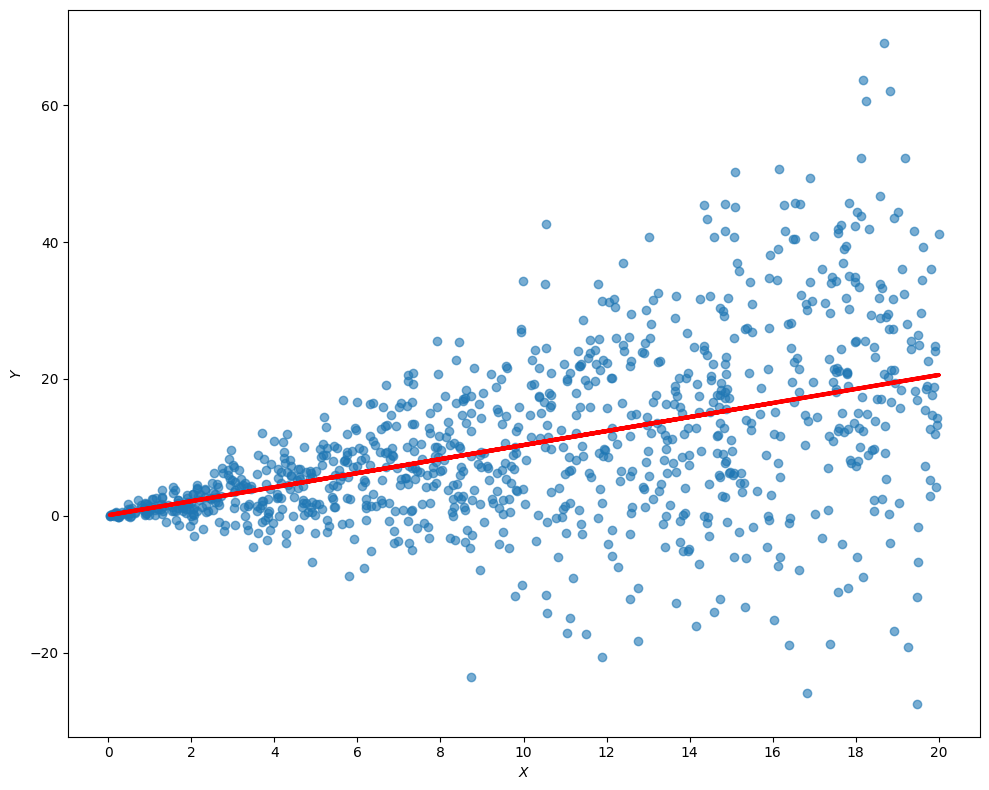

In [104]:
def plot_model(model, X, y):
    plt.figure(figsize=(10, 8))
    plt.scatter(X, y, alpha=0.6)
    plt.plot(X, model.predict(X), color="red", linewidth=3)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_model(linear_model, X_test, y_test)

Now that we have a trained model, we wish to *conformalize* it. The simplest algorithm to conformalize a model is the *split conformal* algorithm.

In this section, we are using the split conformal algorithm for the regression task, but as we have seen in the lectures, there are many other algorithms conformalization algorithms that rely on splitting the data into fit and calibration setl. Therefore, we will coda a generc class called `SplitConformal` that we will be able to use later for other conformal prediction algorithms of the *split* type.

In order to define our general `SplitConformal` class, we will rely on the following information:
the algorithms using the `SplitConformal` class are different between each other only in two ways:
- the way the *nonconformity scores* are computed,
- the way the *prediction sets* are constructed.

Therefore, we will build the `SplitConformal` class so that it can work with any choice of *nonconformity score function* a *prediction set contruction function*.


**Exercise.** Code the `SplitConformal` class by implementing the following:
1. Attributes:
  - `score_fn`: the nonconformity score function to be used (a function that computes scores between ground truth values and model predictions).
  - `predset_fn`: the prediction set construction function to be used (a function that builds prediction sets from model predictions and quantile values).
  - `scores`: attribute to store the array of calibration nonconformity scores.
  - `quantile`: attribute to store the value of the quantile of order $1-\alpha$ (plus correction).

2. Methods:
  - `__init__`: takes as input the choice of nonconformity score function and prediction set construction function.
  - `compute_scores`: takes as input a numpy array containing ground truth $y$-values and predicted $y$-values, computes the nonconformity scores, and stores them into the attribute `scores`.
  - `compute_quantile`: takes as input the nominal error rate $\alpha$ and computes the quantile of level $1-\alpha$ (taking into account the usual finite-sample correction characteristic of conformal prediction algorithms) on the array of scores saved in the `scores` attribute. **Warning!** You may use the `quantile` function in the `numpy` library, however, make sure you choose the *right* method to compute the quantile values, otherwise the probabilistic guarantee of conformal prediction will no longer be true. (**This is an important point, try and understand the different methods and choose the correct one yourself before checking the solutions!!!**)
  - `predict`: takes as input an array of model predictions and outputs prediction sets (in whatever format the `predset_fn` outputs prediction sets).

In [105]:
class SplitConformal():
    def __init__(self, score_fn, predset_fn):
        self.score_fn = score_fn
        self.predset_fn = predset_fn
        self.scores = None
        self.quantile = None

    def compute_scores(self, y_calib, y_pred_calib):
        self.scores = self.score_fn(y_calib, y_pred_calib)

    def compute_quantile(self, alpha):
        corrected_alpha = np.ceil((1 - alpha) * (len(self.scores) + 1)) / len(self.scores)
        self.quantile = np.quantile(self.scores, corrected_alpha, method="inverted_cdf")

    def predict(self, y_test):
        return self.predset_fn(y_test, self.quantile)

**Exercise.** Code the `abs_difference` and `additive_interval` functions to be used as the arguments of the `SplitConformal` class at initialization.

In [106]:
def abs_difference(y_true, y_pred):
    return np.abs(y_true - y_pred)


def additive_interval(y, interval_length):
    return y - interval_length, y + interval_length

**Exercise.** Use the `SplitConformal` class to conformalize the Linear Regression model with a nominal error rate of 0.1.

In [107]:
alpha = 0.1

y_pred_calib = linear_model.predict(X_calib)
splitcr = SplitConformal(abs_difference, additive_interval)
splitcr.compute_scores(y_calib, y_pred_calib)
splitcr.compute_quantile(0.1)

y_pred_test = linear_model.predict(X_test)
y_lower, y_upper = splitcr.predict(y_pred_test)

**Exercise.** Complete the function `plot_conformalized_data` below and use it to plot the test datset along with the model predictions and the prediction intervals.

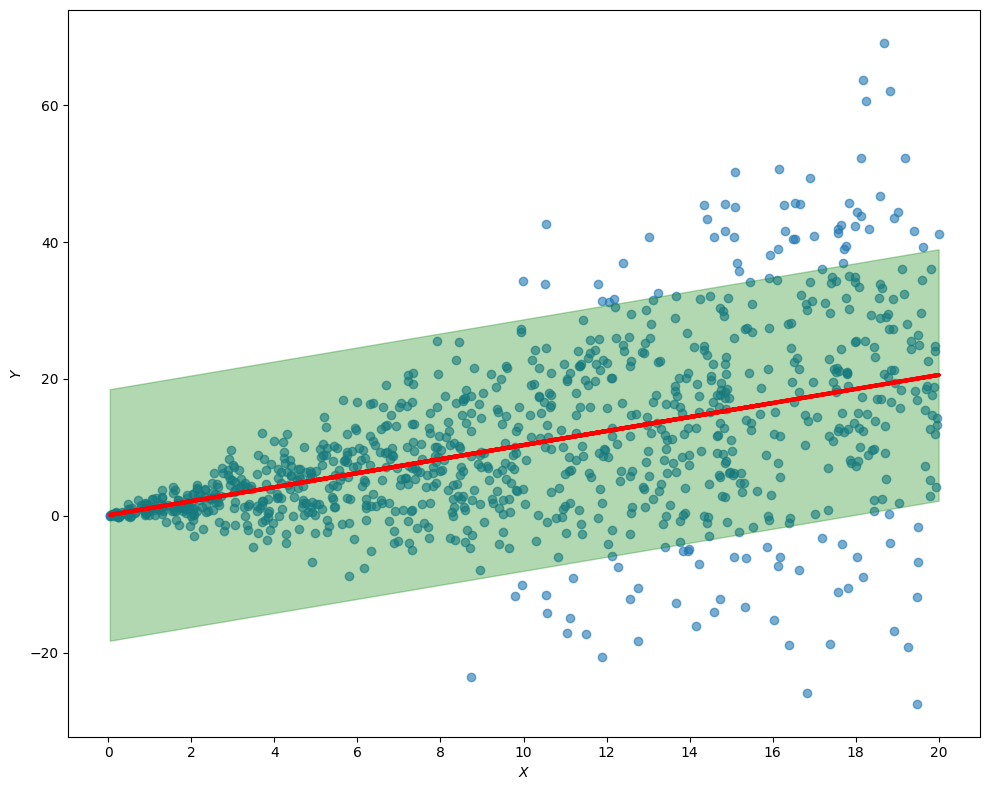

In [108]:
def plot_conformalized_data(X, y, y_pred, y_lower, y_upper):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())

    plt.scatter(X, y, alpha=0.6)
    plt.plot(X, y_pred, color="red", linewidth=3)
    plt.fill_between(
        X[sort_indices].flatten(),
        y_lower[sort_indices],
        y_upper[sort_indices],
        alpha=0.3,
        color="green",
    )
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_conformalized_data(X_test, y_test, y_pred_test, y_lower, y_upper)

**Exercise.** Write a function called `evaluate_conformal_regression` that takes as input an array of ground-truth $y$-values along with an array of the lower limits and an array of the upper limits of the corresponding prediction intervals. It then computes and outputs the following two metrics:
1. `coverage`: The average number of intervals that contain the ground-truth values.
2. `avg_length`: The average length of the intervals.

**Questions.**
1. What value should we expect for the `coverage` metric?
2. What kind of values do we desire for the `avg_length` metric?


In [109]:
def evaluate_conformal_regression(y_test, y_lower, y_upper):
    coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
    avg_length = np.mean(y_upper - y_lower)
    return coverage, avg_length

**Exercise.** Evaluate the conformalized model with the help of the `evaluate_conformal_regression` function and display the results.

In [110]:
coverage, avg_length = evaluate_conformal_regression(y_test, y_lower, y_upper)
print(f"Average prediction intervals width (sharpness): {avg_length:.3f}")
print(f"Average coverage: {coverage:.3f}")

Average prediction intervals width (sharpness): 36.760
Average coverage: 0.896


The evaluation seems to match the desired results. Note however (from the plot) how the interval length is constant, and does not match the heteroskedasticity of the data.

Next, we perform a similar conformalization procedure using the PUNCC library, this will allow us to compare results, but also to learn how the PUNCC library works so that we can use it in the future instead of coding the CP algorithms from scratch.

**Exercise.** Find the tutorial called *Introduction Tutorial* in the Readme page of the PUNCC github repository and dollow the steps presented in the *Conformal Regression* section in order to conformalize the linar regression model above using PUNCC:
1. Train the model using PUNCC rather than fitting it directly.
2. Compute the prediciton intervals.
3. Compute the evaluation metrics.
4. Use PUNCC's visualization tools to visualize the results.

In [111]:
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import SplitCP

# Initilize the linear_model again
linear_model = LinearRegression()

# Do not train the model yet, wrap it as a BasePredictor and let PUNCC do the job later.
base_predictor = BasePredictor(linear_model)

# Wrap the base predictor in a split conformal predictor
# train=True (default) to fit the split conformal predictor
split_cp = SplitCP(base_predictor)

# Fit the split conformal predictor:
# puncc will fit the underlying model on the fit data and
# compute nonconformity scores on the calibration set
split_cp.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib)

Computing the prediction intervals along with the point predictions:

In [112]:
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

Evaluate the average coverage and interval length

In [113]:
from deel.puncc import metrics

coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {coverage:.2f}")
print(f"Average width: {width:.2f}")

Marginal coverage: 0.90
Average width: 36.76


Visualize the results

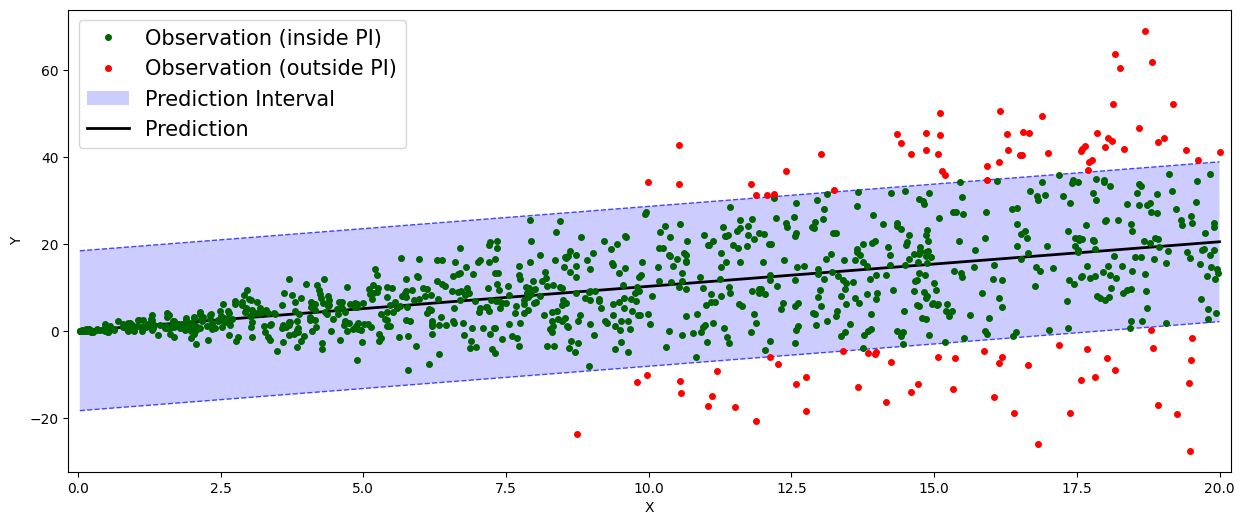

In [114]:
from deel.puncc.plotting import plot_prediction_intervals

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    y_pred=y_pred,
    X=X_test[:, 0],
)
plt.show()

## 3. Cross-Validation+ (CV+)
As seen during the lecture, practitionners are not always willing to sacrifice part of the training data for the calibration phase. Of course, this is not a problem for our toy case, where we can generate as many extra exmaple as we wish... but we will nevertheless implemnt
the *Cross-Validation+* algorithm, which allows to use the whole training dataset for training, instead of splitting it into a proper training set and a calibration set. Of course, this comes at the cost of having to train multiple models.

**Exercise.** Use the `KFold` class from `scikit-learn` to:
1. Train 10 different linear regression models according to the CV+ algorithm.
2. Compute the nonconformity scores on each of the folds.

Store the models into a list of models called `models` and the scores in a numpy array called `scores`.

**Warning.** Read carefully the documentaion of the `Kfold` function, we will be using it again further down to compute the prediction sets and the point predictions on the test sets, and we need to make sure that the data is split in the exact same folds both times!

In [115]:
from sklearn.model_selection import KFold

# Define the k-fold cross-validation scheme
kf = KFold(n_splits = 10, shuffle = True, random_state = 31)

# Initialize empty lists to store models and scores
models = []
scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Initialize the linear model
    linear_model = LinearRegression()

    # Train the model
    linear_model.fit(X_train_fold, y_train_fold)
    models.append(linear_model)

    # Compute predictions on the validation set
    y_pred_val = linear_model.predict(X_val_fold)

    # Compute nonconformity scores and append to lists
    scores.append(abs_difference(y_val_fold, y_pred_val))

# concatenate scores into a numpy array
scores = np.concatenate(scores)

**Exercise.** Use the CV+ algorithm to produce prediction intervals for nominal $\alpha=0.1$. Compute point predictions on the test set by averaging accross the 10 different models.

In [116]:
# Compute Prediction intervals:

# Set value of nominal error rate alpha
alpha = 0.1

# Initialize lower and upper arrays
y_pred_test = []
y_lower = []
y_upper = []

for fold, (train_index, val_index) in enumerate(kf.split(scores)):

    # Compute predictions on k-th model
    y_pred = models[fold].predict(X_test)
    y_pred_test.append(y_pred)

    # Extract scores
    scores_fold = scores[val_index]

    # Update lower and upper arrays
    y_lower.append(y_pred[:, np.newaxis] - scores_fold[np.newaxis, :])
    y_upper.append(y_pred[:, np.newaxis] + scores_fold[np.newaxis, :])


# Convert the lists y_lower and y_upper into numpy arrays
y_pred_test = np.stack(y_pred_test)
y_lower = np.concatenate(y_lower, axis=1)
y_upper = np.concatenate(y_upper, axis=1)

# Compute predictions by averaging over the k models
y_pred_test = np.mean(y_pred_test, axis=0)

# Compute prediction intervals using the numpy quantile function
alpha_lower_corrected = np.floor(alpha * (len(scores) + 1)) / len(scores)
alpha_upper_corrected = np.ceil((1 - alpha) * (len(scores) + 1)) / len(scores)
y_lower = np.quantile(y_lower, alpha_lower_corrected, axis=1, method="inverted_cdf")
y_upper = np.quantile(y_upper, alpha_upper_corrected, axis=1, method="inverted_cdf")

**Exercise.** Evaluate and plot the results.

Average prediction intervals width (sharpness): 36.494
Average coverage: 0.894


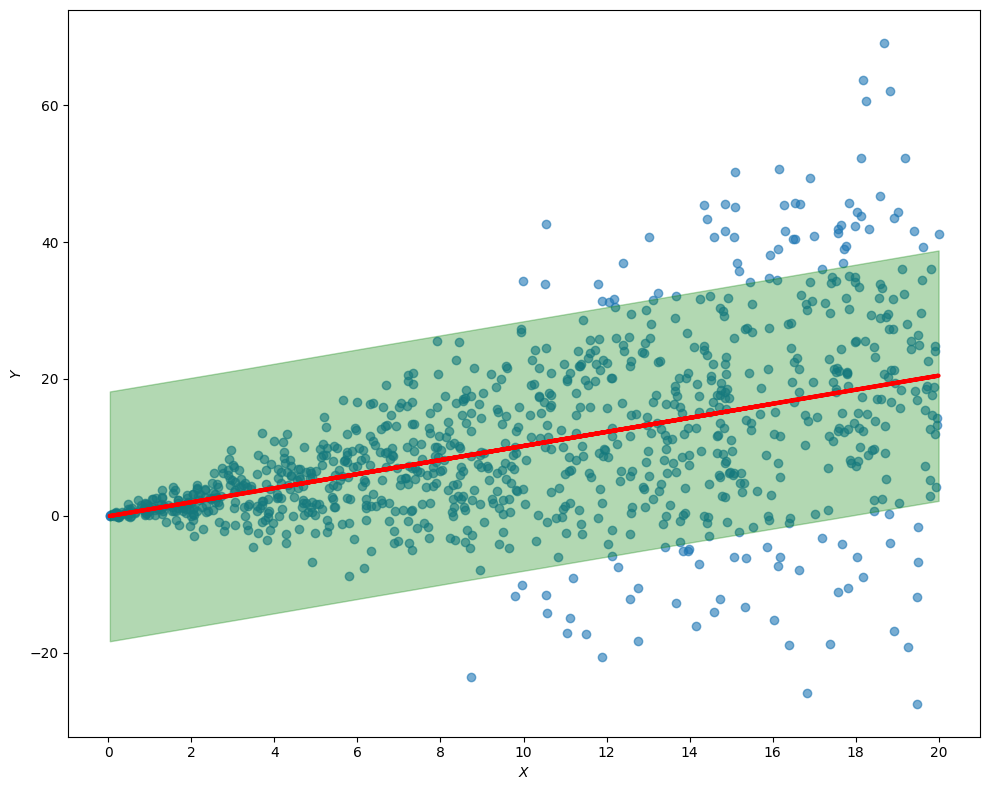

In [117]:
coverage, avg_length = evaluate_conformal_regression(y_test, y_lower, y_upper)
print(f"Average prediction intervals width (sharpness): {avg_length:.3f}")
print(f"Average coverage: {coverage:.3f}")

plot_conformalized_data(X_test, y_test, y_pred_test, y_lower, y_upper)

**Exercise.** Perform the Cross-Validation using PUNCC and compare the result, there is no tutorial for this algorithm, but you can check the following section in the documentation to help yourself:

https://deel-ai.github.io/puncc/regression.html#deel.puncc.regression.CVPlus

In [118]:
from deel.puncc.regression import CVPlus

# Create a linear regression model and wrap it in a predictor
lr_model = LinearRegression()
base_predictor = BasePredictor(lr_model)

# Wrap the base predictor in a split conformal predictor, choose K=5
cvplus = CVPlus(base_predictor, K=10, random_state=31)

# Fit the CV+ predictor
cvplus.fit(X=X_train, y=y_train)

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = cvplus.predict(X_test, alpha=0.1)


Marginal coverage: 0.89
Average width: 36.46


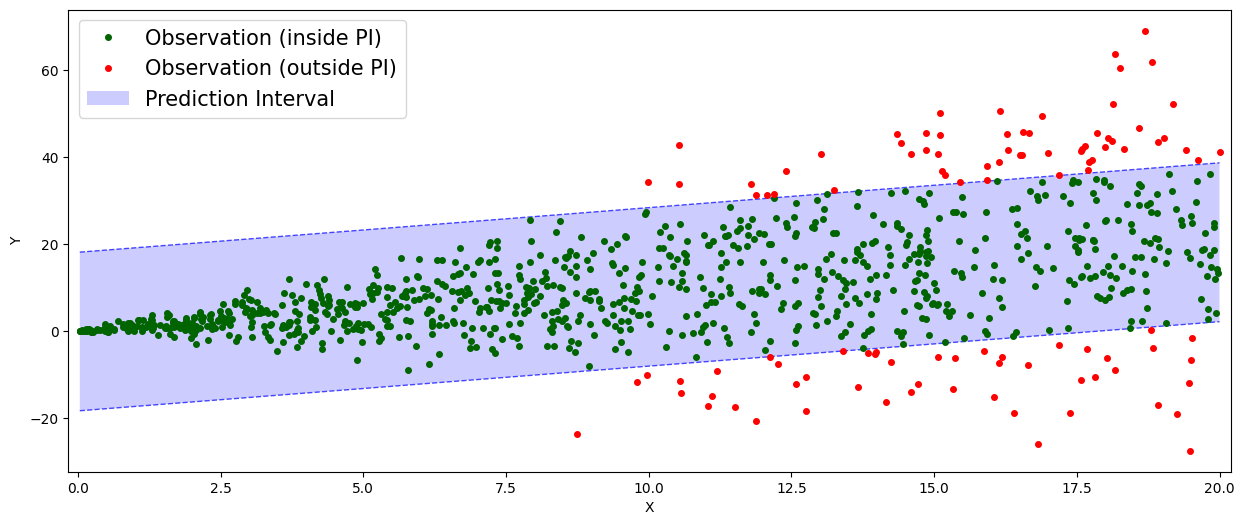

In [119]:
# Evaluate the sharpness and coverage of the prediction intervals
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {coverage:.2f}")
print(f"Average width: {width:.2f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    y_pred=y_pred,
    X=X_test[:, 0],
)
plt.show()

Note that whereas the guarantee provided by the CV+ method is
$$\mathbb{P}(Y_{n+1}\in \hat{C}_\alpha(X_{n+1})) \geq 1-2\alpha,$$
however the achieved coverage rate is rather close to $1-\alpha$.

**Question.** How can you explain this?

## 4. Conformal Quantile Regression
We now turn to the problem of the *constant* prediction intervals. As we can see in the plots above, the coverage rate of $1-\alpha$ is obtained by over-covering in the low-variance regions and over-covering in the high variance regions. We next consider the *Conformalized Quantile Regression (CQR)* algorithm, the purpose of which is to generate prediction sets that are more adapted to the heteroskedasticity of the data. CQR extends traditional quantile regression by incorporating conformal prediction techniques, allowing us to construct predictive intervals with state-of-the-art performance and guaranteed coverage (under data exchangeability).

**Exercise.** Train lower and upper quantile models for a nominal eror rate $\alpha$ of 0.1, using the `GradientBoostingRegressor` model with 10 estimators from the `sklearn.ensemble` module.

**Careful!** The CQR algorithm is a kind of *split conformal* algorithm, so we neet to use the *fit* data split to train the models, and hold out the *calibration* data split for the calibration phase.

In [120]:
from sklearn.ensemble import GradientBoostingRegressor

# Lower quantile regressor
lower_quantile_model = GradientBoostingRegressor(
    loss="quantile", alpha=alpha / 2, n_estimators=10
)
# Upper quantile regressor
upper_quantile_model = GradientBoostingRegressor(
    loss="quantile", alpha=1 - alpha / 2, n_estimators=10
)

# Train the models
lower_quantile_model.fit(X_fit, y_fit)
upper_quantile_model.fit(X_fit, y_fit)

GradientBoostingRegressor(alpha=0.95, loss='quantile', n_estimators=10)

**Exercise.** Complete the `plot_quantile_model` function below and use it to plot the test examples along with the lower and upper quantile model predictions.

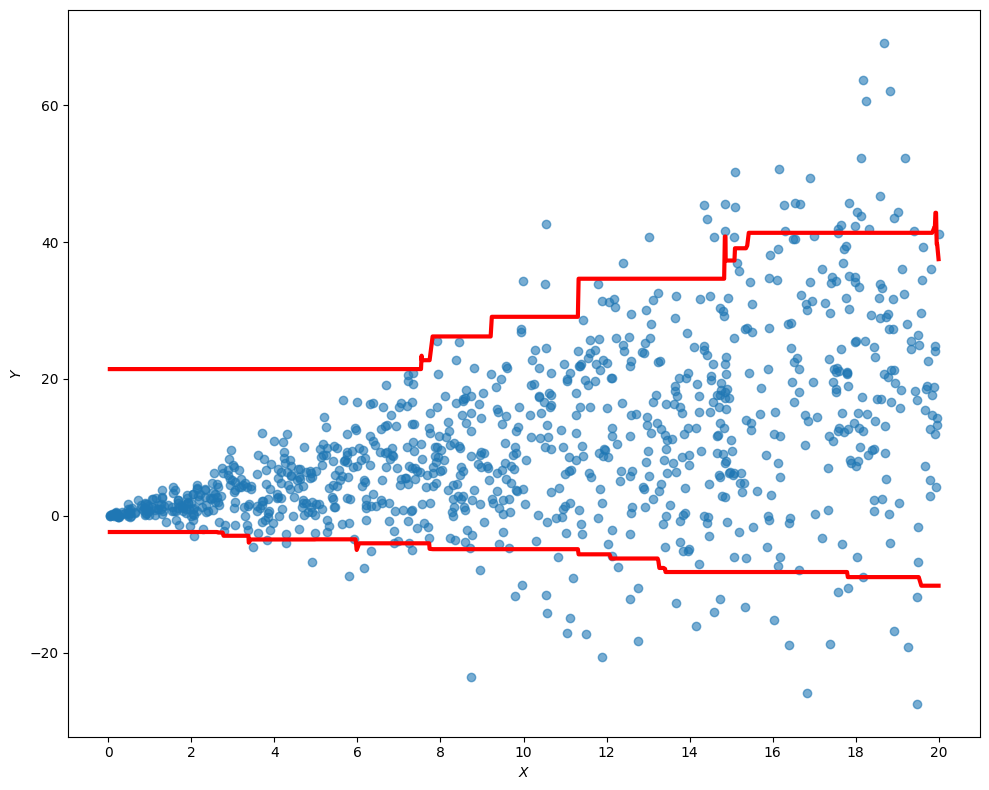

In [121]:
def plot_quantile_models(X, y, lower_quantile_model, upper_quantile_model):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())
    X_sorted = X[sort_indices]
    y_sorted = y[sort_indices]
    plt.scatter(X, y, alpha=0.6)
    plt.plot(X_sorted, lower_quantile_model.predict(X_sorted), color="red", linewidth=3)
    plt.plot(X_sorted, upper_quantile_model.predict(X_sorted), color="red", linewidth=3)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()


plot_quantile_models(X_test, y_test, lower_quantile_model, upper_quantile_model)

**Exercise.** Code the functions `cqr_score` and `cqr_set` so that we can use them along with the class `SplitConformal` above in order to implement the CQR algorithm. In order to keep a structure compatible with the `SplitConformal` class above, the `y_pred` input to the `cqr_score` and `cqr_set` functions is an array of length 2, where the first element contains the predictions of the lower quantile model and the second one the predictions of the upper quantile model.

**Careful!** There is a typo in the lecture notes!

In [122]:
def cqr_score(y_true, y_pred):
    return np.max(np.stack([y_pred[0] - y_true, y_true - y_pred[1]]), axis=0)

def cqr_set(y_pred, quantile):
    return y_pred[0] - quantile, y_pred[1] + quantile

**Exercise.** Conformalize the quantile regressors using the CQR algorithm and the calibration dataset.

In [123]:
y_pred_calib_lower = lower_quantile_model.predict(X_calib)
y_pred_calib_upper = upper_quantile_model.predict(X_calib)
y_pred_calib = np.stack([y_pred_calib_lower, y_pred_calib_upper])

alpha = 0.1

splitcr = SplitConformal(cqr_score, cqr_set)

splitcr.compute_scores(y_calib, y_pred_calib)
splitcr.compute_quantile(alpha)

y_pred_test_lower = lower_quantile_model.predict(X_test)
y_pred_test_upper = upper_quantile_model.predict(X_test)
y_pred_test = np.stack([y_pred_test_lower, y_pred_test_upper])
y_lower, y_upper = splitcr.predict(y_pred_test)

**Exercise.** Evaluate and visualize the results of the CQR conformalized model-

Average prediction intervals width (sharpness): 34.110
Average coverage: 0.910


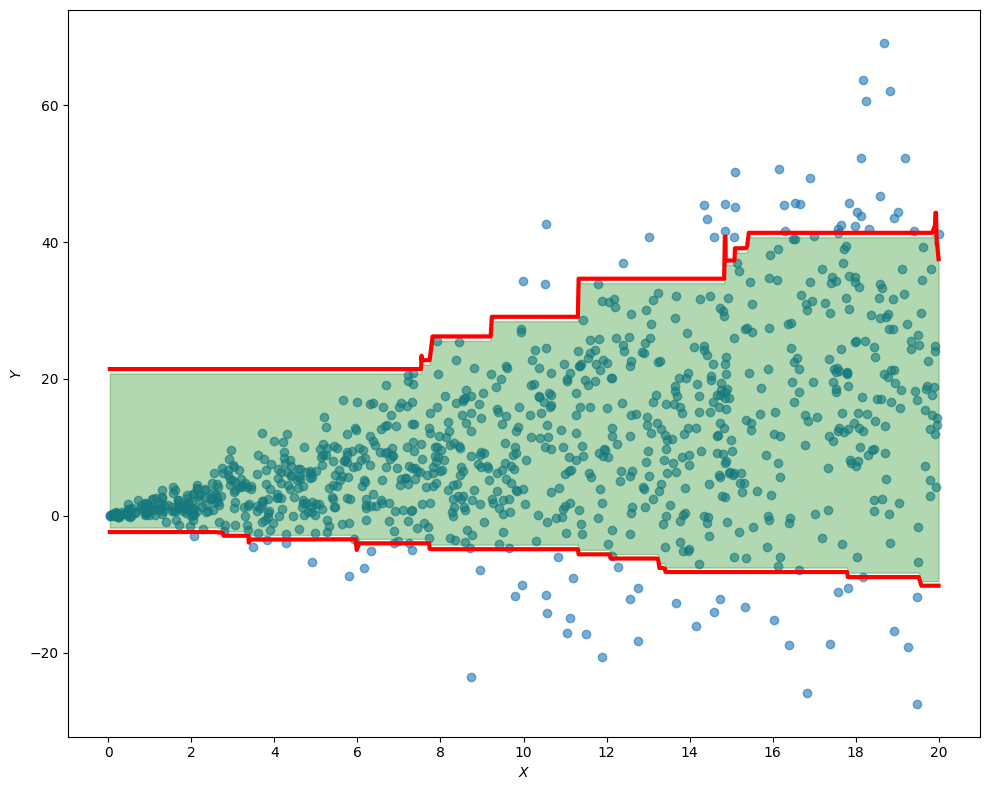

In [124]:
coverage, avg_length = evaluate_conformal_regression(y_test, y_lower, y_upper)
print(f"Average prediction intervals width (sharpness): {avg_length:.3f}")
print(f"Average coverage: {coverage:.3f}")

def plot_cqr_conformalized_data(X, y, y_pred_lower, y_pred_upper, y_lower, y_upper):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())
    X_sorted = X[sort_indices]
    y_pred_lower_sorted = y_pred_lower[sort_indices]
    y_pred_upper_sorted = y_pred_upper[sort_indices]
    y_lower_sorted = y_lower[sort_indices]
    y_upper_sorted = y_upper[sort_indices]

    plt.scatter(X, y, alpha=0.6)
    plt.plot(X_sorted, y_pred_lower_sorted, color="red", linewidth=3)
    plt.plot(X_sorted, y_pred_upper_sorted, color="red", linewidth=3)
    plt.fill_between(
        X_sorted.flatten(),
        y_lower_sorted,
        y_upper_sorted,
        alpha=0.3,
        color="green",
    )
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_cqr_conformalized_data(X_test, y_test, y_pred_test_lower, y_pred_test_upper, y_lower, y_upper)

**Questions.**
- What do you observe?
- Is this the expected behavior? Why?
- How does the average interval width compare with the previous methods?

**Exercise.** Implement the CQR algorithm in with PUNCC and compare the results with the ones obtained above.

Marginal coverage: 0.89
Average width: 36.46


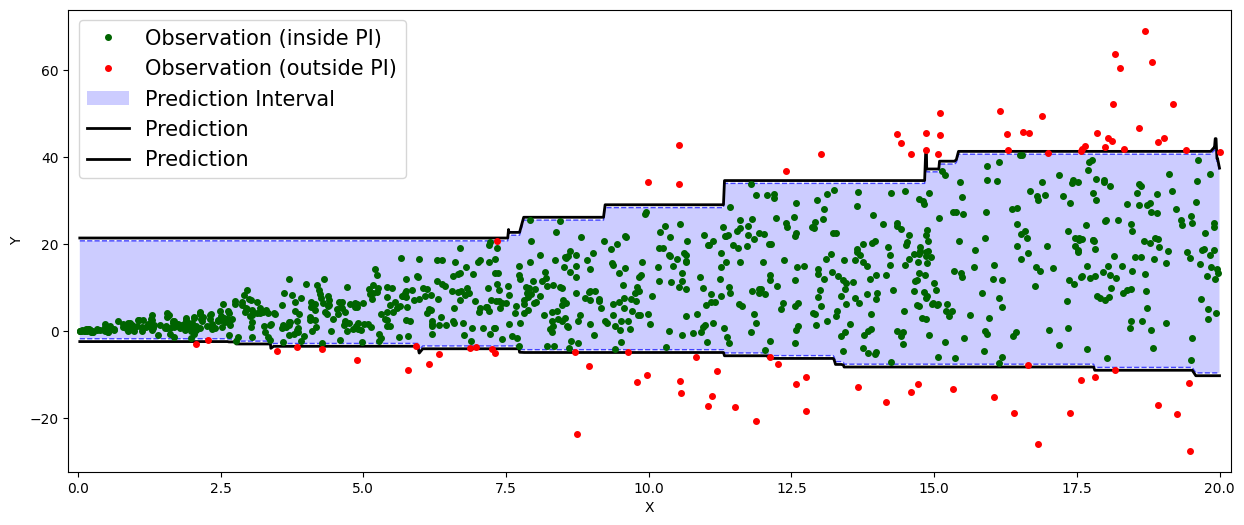

In [128]:
from deel.puncc.api.prediction import DualPredictor
from deel.puncc.regression import CQR

# Lower quantile regressor
lower_quantile_model = GradientBoostingRegressor(
    loss="quantile", alpha=alpha / 2, n_estimators=10
)
# Upper quantile regressor
upper_quantile_model = GradientBoostingRegressor(
    loss="quantile", alpha=1 - alpha / 2, n_estimators=10
)

# Wrap the upper and lower quantile models in a dual predictor
dualpredictor = DualPredictor([lower_quantile_model, upper_quantile_model])

# Initialize the CQR conformal predictor
# train=True to use the train dual predictor
cqr = CQR(dualpredictor, train=True)

# Fit the CQR predictor and compute the nonconformity scores
cqr.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib)

# Compute prediction intervals and metrics on the test set
y_pred, y_lower, y_upper = cqr.predict(X_test, alpha)  # TODO

# Compute marginal coverage and average width of the prediction intervals
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                             y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_pred=y_pred,
    y_true=y_test,
    y_pred_lower=y_lower,
    y_pred_upper=y_upper,
    X=X_test[:, 0],
)
plt.show()

# Part II: Conformal Classification

The objective of this section is to train a small neural network on the MNIST dataset and apply the Conformal Classification algorithms seen during the lecture.

 ## 1. Dataset
**Exercise.**
1. Import the MNIST dataset from keras.
2. Split the training set into a proper training set, which we call the `fit` dataset, and a calibration set. Use the first 50_000 training points for the fit dataset and the remaining ones for the calibration dataset.
3. Convert the labels to categorical, and save them into new arrays.

In [148]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST Database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocessing: reshaping and standardization
X_train = X_train.reshape((len(X_train), 28, 28))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((len(X_test), 28 , 28))
X_test = X_test.astype('float32') / 255

# Split fit and calib datasets
X_fit, X_calib  = X_train[:50000], X_train[50000:]
y_fit, y_calib  = y_train[:50000], y_train[50000:]

# One hot encoding of classes
y_fit_cat = to_categorical(y_fit)
y_calib_cat = to_categorical(y_calib)
y_test_cat = to_categorical(y_test)

## 2. Model

**Exercise.** Define a simple convolutional neural network having the following sequential architecture:
- A convolution with kernel size 3 and 16 channels.
- A ReLU activation.
- A max pooling layer with kernel size 2.
- A convolution with kernel size 3 and 32 channels.
- A reLU activation.
- A max pooling layer with kernel size 2.
- A Fully connected layer with 10 neurons.
- A softmax activation.

In [149]:
from tensorflow import random
from tensorflow import keras
from tensorflow.keras import layers

random.set_seed(0)
keras.utils.set_random_seed(0)

# Classification model: convnet composed of two convolution/pooling layers
# and a dense output layer
nn_model = keras.Sequential(
   [
      keras.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(10, activation="softmax"),
   ]
)

## 3. Training

**Exercise.** Train the model using the Adam optimizer, and the categorical cross-entropy loss. Plot the training and validation accuracy while training, with 10% of the fit data left out for the validation set.

Train the model for 2 epochs with a batch size of 256.

In [150]:
# Train the model for two epochs
nn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
nn_model.fit(X_fit, y_fit_cat, epochs=2, batch_size=256, validation_split=0.1, verbose=1)

Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.6851 - loss: 1.1686 - val_accuracy: 0.9278 - val_loss: 0.2383
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - accuracy: 0.9425 - loss: 0.1921 - val_accuracy: 0.9554 - val_loss: 0.1490


## 4. Least Ambiguous Set-Valued Classifiers (LAC)
We now implement the LAC algorithm seen during the lecture.

**Exercise.** Define a `lac_score` and a `lac_set` function in order to be used with the `SplitConformal` class above.

In [151]:
def lac_score(probas, labels):
    scores = [1 - p[l] for p, l in zip(probas, labels)]
    return np.array(scores)

def lac_set(probas, quantile):
    return [np.where(p > 1 - quantile)[0] for p in probas]

**Exercise.** Conformalize the classification model.

In [152]:
y_pred_calib = nn_model.predict(X_calib)
y_pred_test = nn_model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [153]:
alpha = 0.1

conformal_classifier = SplitConformal(lac_score, lac_set)

conformal_classifier.compute_scores(y_pred_calib, y_calib)
conformal_classifier.compute_quantile(alpha)

y_predset_test = conformal_classifier.predict(y_pred_test)

**Exercise.** Evaluate the results by computing the average coverage and average size of the prediction sets on the test set.

In [154]:
def eval_conformal_classifier(y_true, y_predset):
    coverage = 0
    avg_size = 0
    for i in range(len(y_true)):
        if y_true[i] in y_predset[i]:
            coverage += 1
        avg_size += len(y_predset[i])


    coverage /= len(y_true)
    avg_size /= len(y_true)
    return coverage, avg_size

coverage, avg_size = eval_conformal_classifier(y_test, y_predset_test)
print(f"Average size of prediction sets: {avg_size:.3f}")
print(f"Average coverage: {coverage:.3f}")

Average size of prediction sets: 0.902
Average coverage: 0.895


**Exercise.** Plot a random images along with the prediction set.

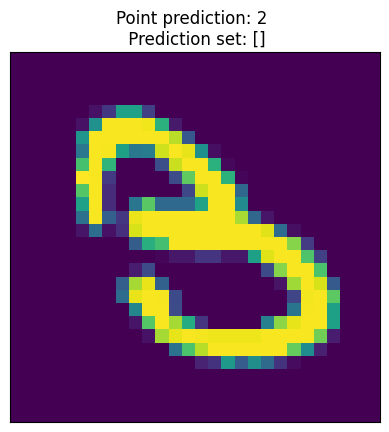

In [157]:
sample = 18

plt.imshow(X_test[sample].reshape((28,28)))
_ = plt.title(f"Point prediction: {np.argmax(y_pred[sample])} \n Prediction set: {y_predset_test[sample]}")
_ = plt.xticks([])
_ = plt.yticks([])

**Questions.**
1. How come the average size of the prediction sets is smaller than 1 ?
2. Some of the prediction sets are empty, they contain no labels. Why? Do you think that this is an Ok behavior?

## 5. Regularized Adaptive Prediction Sets
**Exercise.** Follow the *Introduction Tutorial* in PUNCC, the section on *Conformal Classification* to implement the RAPS method as in the tutorial. Compare the results thus obtained with those obtained from the LAC method.

In [158]:
# Classification model: convnet composed of two convolution/pooling layers
# and a dense output layer
nn_model = keras.Sequential(
   [
      keras.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(10, activation="softmax"),
   ]
)

In [159]:
from deel.puncc.api.prediction import BasePredictor

# The compilation details are gathered in a dictionnary
compile_kwargs = {"optimizer":"adam", "loss":"categorical_crossentropy","metrics":["accuracy"]}

# Create a predictor to wrap the convnet model defined earlier
class_predictor = BasePredictor(nn_model, is_trained=False, **compile_kwargs)

In [160]:
from deel.puncc.classification import RAPS

# Coverage target is 1-alpha = 90%
alpha = .1

# Instanciate the RAPS wrapper around the convnet predictor.
# The `train` argument is set to True such that the convnet model is trained
# before the calibration. You can initialize it to False if the model is
# already trained and you want to save time.
aps_cp = RAPS(class_predictor, lambd=0, train=True)

# The train details of the convnet are gathered in a dictionnary
fit_kwargs = {"epochs":2, "batch_size":256, "validation_split": .1, "verbose":1}

# Train model (argument `train` is True) on the fitting dataset (w.r.t. the fit config)
# and compute the residuals on the calibration dataset.
aps_cp.fit(X_fit=X_fit, y_fit=y_fit_cat, X_calib=X_calib, y_calib=y_calib, **fit_kwargs)

# The `predict` returns the output of the convnet model `y_pred` and
# the calibrated prediction set `set_pred`.
y_pred, set_pred = aps_cp.predict(X_test, alpha=alpha)

Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 35s 190ms/step - accuracy: 0.6563 - loss: 1.3436 - val_accuracy: 0.9428 - val_loss: 0.1976
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 141ms/step - accuracy: 0.9528 - loss: 0.1607 - val_accuracy: 0.9634 - val_loss: 0.1221
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [161]:
mean_coverage = metrics.classification_mean_coverage(y_test, set_pred)
mean_size = metrics.classification_mean_size(set_pred)

print(f"Empirical coverage : {mean_coverage:.2f}")
print(f"Average set size : {mean_size:.2f}")

Empirical coverage : 0.89
Average set size : 1.00


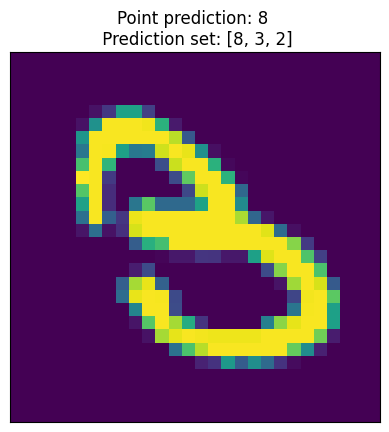

In [162]:
sample = 18

plt.imshow(X_test[sample].reshape((28,28)))
_ = plt.title(f"Point prediction: {np.argmax(y_pred[sample])} \n Prediction set: {set_pred[sample]}")
_ = plt.xticks([])
_ = plt.yticks([])

# To go further

1. Code the APS and RAPS algorithms from scratch without using PUNCC.
2. Check out the MAPIE library, which is a nice alternative to PUNCC.
3. Check out the algorithms for Conformal Anomaly Detection and Conformal Object Detection in PUNCC.